In [17]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:         385376       52736      258368        3438       74271      315858
Swap:         68165       12937       55228


In [4]:
from __future__ import division
import os, time
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
# import cv2
import glob
import pickle
from tqdm import tqdm
import rawpy
%matplotlib inline

input_dir = './Dataset/Sony/short/'
gt_dir = './Dataset/Sony/long/'

result_dir = './results_UNet/'
model_save_path = './results_UNet/net_weights/'
if os.path.isdir(model_save_path) is not True:
    os.makedirs(model_save_path, exist_ok=True)

In [5]:
if torch.cuda.is_available():
    deviceTag = torch.device('cuda')
else:
    deviceTag = torch.device('cpu')
print(deviceTag)

cuda


# LOAD DATASET

In [6]:
# get train IDs
train_fns = glob.glob(gt_dir + '0*.ARW')
train_ids = [int(os.path.basename(train_fn)[0:5]) for train_fn in train_fns]

ps = 512  # patch size for training
save_freq = 500

DEBUG = 0
if DEBUG == 1:
    save_freq = 2
    train_ids = train_ids[0:5]


# UNET MODULES

In [7]:
class conv_lrelu(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_lrelu, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_ch,out_ch,3, padding = 1),nn.LeakyReLU())

    def forward(self, x):
        x = self.conv(x)
        return x
    
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.conv1 = conv_lrelu(in_ch,out_ch)
        self.conv2 = conv_lrelu(out_ch,out_ch)
        self.down =  nn.MaxPool2d((2,2))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.down(x)
        return x
    

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()       
        self.up =  nn.UpsamplingBilinear2d(scale_factor = 2)
        self.conv1 = conv_lrelu(in_ch,out_ch) 
        self.conv2 = conv_lrelu(out_ch,out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_ch = 4, CH_PER_SCALE = [32,64,128,256,512], out_ch = 12):
        super(UNet, self).__init__()
        self.inc = conv_lrelu(in_ch, CH_PER_SCALE[0])
        self.inc2 = conv_lrelu(CH_PER_SCALE[0], CH_PER_SCALE[0])
        self.down1 = down(CH_PER_SCALE[0], CH_PER_SCALE[1]) 
        self.down2 = down(CH_PER_SCALE[1],CH_PER_SCALE[2])
        self.down3 = down(CH_PER_SCALE[2],CH_PER_SCALE[3])                
        self.down4 = down(CH_PER_SCALE[3],CH_PER_SCALE[4])                
        self.up1 = up(CH_PER_SCALE[4]+CH_PER_SCALE[3],CH_PER_SCALE[3])
        self.up2 = up(CH_PER_SCALE[3]+CH_PER_SCALE[2],CH_PER_SCALE[2])
        self.up3 = up(CH_PER_SCALE[2]+CH_PER_SCALE[1],CH_PER_SCALE[1])
        self.up4 = up(CH_PER_SCALE[1]+CH_PER_SCALE[0],CH_PER_SCALE[0])
        self.outc = nn.Conv2d(CH_PER_SCALE[0], out_ch, 1, padding = 0)

    def forward(self, x):
        x0 = self.inc(x)
        x0 = self.inc2(x0)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x3_up = self.up1(x4,x3)
        x2_up = self.up2(x3_up,x2)
        x1_up = self.up3(x2_up,x1)
        out = self.up4(x1_up,x0)
        out = self.outc(out)
        out = F.pixel_shuffle(out,2) ## Paper final step rearranges 12 channes to 3 RGB channels
#         out = F.hardtanh(out, min_val=0, max_val=1) #Clamp the top and bottom to 0,1 since pixels can only be in this value
        return out
    

# Helper Functions for packing raw and saving images

In [8]:
def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out

In [9]:
# Raw data takes long time to load. Keep them in memory after loaded.
gt_images = [None] * 6000
input_images = {}
input_images['300'] = [None] * len(train_ids)
input_images['250'] = [None] * len(train_ids)
input_images['100'] = [None] * len(train_ids)

g_loss = np.zeros((5000, 1))

allfolders = glob.glob(result_dir + '*0')

for folder in allfolders:
    lastepoch = np.maximum(epochs, int(folder[-4:]))

# Training 

In [ ]:
model = UNet(in_ch = 4, out_ch = 12)
model = model.cuda()
model = model.train()

In [ ]:
def process_img(input_raw_img, model, ratio):
    ## Process image(s) using the given model
    # input_raw_img: numpy array, dimension: (Batch,Height,Width,Channel)
    # ratio: numpy array, dimension: (Batch,)
    model.eval();
    model.to(deviceTag)
    ratio = ratio.reshape(ratio.shape[0],1,1,1)
    input_raw_img = np.transpose(input_raw_img, [0,3,1,2]).astype('float32')*ratio
    input_tensor = torch.from_numpy(input_raw_img.copy()).float().to(deviceTag)
    with torch.no_grad():
        output_tensor = model(input_tensor)
    output_img = output_tensor.cpu().numpy()
    output_img = np.transpose(output_img, [0,2,3,1])
    
    return output_img
    
def validate(model, input_list, gt_list, block_size = None, batch_size = 8):
    assert len(input_list) == len(gt_list)
    
    model.eval();
    PSNR_list = []
    
    for i in range(len(input_list)//batch_size):
        if i%10 == 0:
            print(i)
        input_raw_img_batch = []
        gt_img_batch = []
        ratio_batch = []
        for b in range(batch_size):
            if i*batch_size+b < len(input_list):
                in_path = input_list[i*batch_size+b]
                gt_path = gt_list[i*batch_size+b]
            else:
                break
            in_fn = os.path.basename(in_path)
            gt_fn = os.path.basename(gt_path)
            in_exposure = float(in_fn[9:-5])
            gt_exposure = float(gt_fn[9:-5])
            ratio = min(gt_exposure / in_exposure, 300)
        
            raw = rawpy.imread(in_path)
            input_raw_img = pack_raw(raw)
            
            gt_raw = rawpy.imread(gt_path)
            gt_img = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_img = np.float32(gt_img / 65535.0)
            
            if block_size is not None:
                i_cut, j_cut = np.random.randint(0,input_raw_img.shape[0]-block_size), np.random.randint(0,input_raw_img.shape[1]-block_size)
                gt_img = gt_img[i_cut*2:i_cut*2+block_size*2, j_cut*2:j_cut*2+block_size*2, :]
                input_raw_img = input_raw_img[i_cut:i_cut+block_size, j_cut:j_cut+block_size, :]
            
            ratio_batch.append(ratio)
            input_raw_img_batch.append(input_raw_img)
            gt_img_batch.append(gt_img)
        
        input_raw_img_batch = np.array(input_raw_img_batch)
        ratio_batch = np.array(ratio_batch)
        gt_img_batch = np.array(gt_img_batch)
        
        output_img_batch = process_img(input_raw_img_batch, model, ratio_batch)
        plt.figure()
        plt.imshow(gt_img_batch[0,:,:,:])
        plt.title("Ground Truth")
        plt.figure()
        plt.imshow(output_img_batch[0,:,:,:])
        plt.title("Predicted patch")
        MSE = np.mean((output_img_batch.reshape(output_img_batch.shape[0],-1) - gt_img_batch.reshape(gt_img_batch.shape[0],-1))**2, axis = 1)
        PSNR_batch = 10*np.log10(1/MSE)
        PSNR_list.append(list(PSNR_batch))
    
    Val_PSNR = np.mean(PSNR_list)
        
    return Val_PSNR

In [ ]:
learning_rate = 1e-4
batch_num = 8;
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1) #Step Scheduler. 
criterion = nn.MSELoss()

Start_epoch = 0
epochs = 4000
TrainingLossData = np.zeros(epochs)

for epoch in range(Start_epoch, Start_epoch+epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    epoch_loss = 0 ## Set Epoch Loss
    count = 0;
    batches_processed = 0
    ##This version has a batch size of 1. In the future conside increasing batchsize
    for ind in np.random.permutation(len(train_ids)):    
        # get the path from image id
        train_id = train_ids[ind]
        in_files = glob.glob(input_dir + '%05d_00*.ARW' % train_id)
        in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        st = time.time()

        if input_images[str(ratio)[0:3]][ind] is None:
            raw = rawpy.imread(in_path)
            input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

        # crop
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))
        #(1, 512, 512, 4)
        #(1, 1024, 1024, 3)
        input_patch = np.transpose(input_patch, (0,3,1,2))
        input_patch = torch.from_numpy(input_patch.copy()).cuda()
        gt_patch = np.transpose(gt_patch, (0,3,1,2))
        gt_patch = torch.from_numpy(gt_patch.copy()).cuda()
        ##Batch concatenation
        if count%(batch_num)==0:
            input_patch_all = input_patch
            gt_patch_all = gt_patch
        else:
            input_patch_all = torch.cat([input_patch_all, input_patch], dim=0)
            gt_patch_all = torch.cat([gt_patch_all, gt_patch], dim=0)
        ##Every N batches we ship it back 
        if count%(batch_num)==batch_num-1:
            #print(input_patch_all.shape)
            img_pred = model.forward(input_patch_all)
            loss = criterion(img_pred, gt_patch_all)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batches_processed += 1
            ##print(epoch_loss/count);
        count = count +1
    scheduler.step()
    print('Epoch finished ! Loss: {}'.format(epoch_loss / batches_processed))
    if epoch == 0:
        trainF= open(result_dir+"TrainingEpoch.txt","w+")
        trainF.write('Epoch,Train_loss\n')
        trainF.write('{},{}\n'.format(epoch, epoch_loss / batches_processed))
        trainF.close()
    else:
        trainF= open(result_dir+"TrainingEpoch.txt","a")
        trainF.write('{},{}\n'.format(epoch, epoch_loss / batches_processed))
        trainF.close()
    TrainingLossData[epoch] = epoch_loss / batches_processed ## Save for plotting
    ################################################ [TODO] ###################################################
    # Perform validation with eval_net() on the validation data
    # Save the model after every 10 epochs. This save our Memory on HPC.
    ##Save Top results after 95%
    if epoch > epochs*0.98:
        torch.save(model.state_dict(),model_save_path + 'sony{}.pth'.format(epoch + 1))
    if epoch%100 == 0:
        torch.save(model.state_dict(),model_save_path + 'sony{}.pth'.format(epoch + 1))


Starting epoch 1/4000.


<ipython-input-26-7e342c66ea74>:21: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-26-7e342c66ea74>:21: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-26-7e342c66ea74>:21: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]


Epoch finished ! Loss: 0.10495519358664751
Starting epoch 2/4000.
Epoch finished ! Loss: 0.0769632738083601
Starting epoch 3/4000.
Epoch finished ! Loss: 0.05050266226753593
Starting epoch 4/4000.
Epoch finished ! Loss: 0.04585591088980436
Starting epoch 5/4000.
Epoch finished ! Loss: 0.04093110635876655
Starting epoch 6/4000.
Epoch finished ! Loss: 0.028498487547039986
Starting epoch 7/4000.
Epoch finished ! Loss: 0.02000041860155761
Starting epoch 8/4000.
Epoch finished ! Loss: 0.019305308954790233
Starting epoch 9/4000.
Epoch finished ! Loss: 0.019606308871880175
Starting epoch 10/4000.
Epoch finished ! Loss: 0.015957982605323197
Starting epoch 11/4000.
Epoch finished ! Loss: 0.014912858372554183
Starting epoch 12/4000.
Epoch finished ! Loss: 0.015517099993303418
Starting epoch 13/4000.
Epoch finished ! Loss: 0.017782425181940197
Starting epoch 14/4000.
Epoch finished ! Loss: 0.018494975520297885
Starting epoch 15/4000.
Epoch finished ! Loss: 0.015692867757752537
Starting epoch 16/4

Epoch finished ! Loss: 0.00747770369052887
Starting epoch 123/4000.
Epoch finished ! Loss: 0.006431291264016181
Starting epoch 124/4000.
Epoch finished ! Loss: 0.00790897801052779
Starting epoch 125/4000.
Epoch finished ! Loss: 0.007001672033220529
Starting epoch 126/4000.
Epoch finished ! Loss: 0.00729156315792352
Starting epoch 127/4000.
Epoch finished ! Loss: 0.026750624587293714
Starting epoch 128/4000.
Epoch finished ! Loss: 0.012500390619970858
Starting epoch 129/4000.
Epoch finished ! Loss: 0.01273907981812954
Starting epoch 130/4000.
Epoch finished ! Loss: 0.009301210637204349
Starting epoch 131/4000.
Epoch finished ! Loss: 0.009395373240113258
Starting epoch 132/4000.
Epoch finished ! Loss: 0.009121432155370712
Starting epoch 133/4000.
Epoch finished ! Loss: 0.008728315797634422
Starting epoch 134/4000.
Epoch finished ! Loss: 0.009153350116685032
Starting epoch 135/4000.
Epoch finished ! Loss: 0.008941899170167744
Starting epoch 136/4000.
Epoch finished ! Loss: 0.0079904046957

Epoch finished ! Loss: 0.0043880277429707345
Starting epoch 242/4000.
Epoch finished ! Loss: 0.004921206156723201
Starting epoch 243/4000.
Epoch finished ! Loss: 0.00542288210708648
Starting epoch 244/4000.
Epoch finished ! Loss: 0.004901342140510678
Starting epoch 245/4000.
Epoch finished ! Loss: 0.004411540227010846
Starting epoch 246/4000.
Epoch finished ! Loss: 0.005076909088529646
Starting epoch 247/4000.
Epoch finished ! Loss: 0.004658920539077372
Starting epoch 248/4000.
Epoch finished ! Loss: 0.004892097483389079
Starting epoch 249/4000.
Epoch finished ! Loss: 0.00435581716010347
Starting epoch 250/4000.
Epoch finished ! Loss: 0.0042998504708521065
Starting epoch 251/4000.
Epoch finished ! Loss: 0.0045913747977465395
Starting epoch 252/4000.
Epoch finished ! Loss: 0.004441853670869023
Starting epoch 253/4000.
Epoch finished ! Loss: 0.004822758270893246
Starting epoch 254/4000.
Epoch finished ! Loss: 0.004117696778848767
Starting epoch 255/4000.
Epoch finished ! Loss: 0.00426884

Epoch finished ! Loss: 0.0037804309744387866
Starting epoch 361/4000.
Epoch finished ! Loss: 0.0035233843489550056
Starting epoch 362/4000.
Epoch finished ! Loss: 0.0039847265928983685
Starting epoch 363/4000.
Epoch finished ! Loss: 0.0038100788136944176
Starting epoch 364/4000.
Epoch finished ! Loss: 0.0035247985855676235
Starting epoch 365/4000.
Epoch finished ! Loss: 0.003988693305291236
Starting epoch 366/4000.
Epoch finished ! Loss: 0.0038016580627299847
Starting epoch 367/4000.
Epoch finished ! Loss: 0.0036117619834840297
Starting epoch 368/4000.
Epoch finished ! Loss: 0.0039001993485726417
Starting epoch 369/4000.
Epoch finished ! Loss: 0.0040987315936945375
Starting epoch 370/4000.
Epoch finished ! Loss: 0.003560662025120109
Starting epoch 371/4000.
Epoch finished ! Loss: 0.003422796167433262
Starting epoch 372/4000.
Epoch finished ! Loss: 0.0035637632943689825
Starting epoch 373/4000.
Epoch finished ! Loss: 0.003441024641506374
Starting epoch 374/4000.
Epoch finished ! Loss: 0

Epoch finished ! Loss: 0.0032847822469193487
Starting epoch 479/4000.
Epoch finished ! Loss: 0.0033098789397627117
Starting epoch 480/4000.
Epoch finished ! Loss: 0.0028613949194550513
Starting epoch 481/4000.
Epoch finished ! Loss: 0.003292521508410573
Starting epoch 482/4000.
Epoch finished ! Loss: 0.0031823937548324465
Starting epoch 483/4000.
Epoch finished ! Loss: 0.003098102437797934
Starting epoch 484/4000.
Epoch finished ! Loss: 0.003230407601222396
Starting epoch 485/4000.
Epoch finished ! Loss: 0.003446487884502858
Starting epoch 486/4000.
Epoch finished ! Loss: 0.003510939807165414
Starting epoch 487/4000.
Epoch finished ! Loss: 0.0036084683262743054
Starting epoch 488/4000.
Epoch finished ! Loss: 0.0032335987547412516
Starting epoch 489/4000.
Epoch finished ! Loss: 0.003036161477211863
Starting epoch 490/4000.
Epoch finished ! Loss: 0.0034884757595136763
Starting epoch 491/4000.
Epoch finished ! Loss: 0.0030909744440577925
Starting epoch 492/4000.
Epoch finished ! Loss: 0.0

Epoch finished ! Loss: 0.0031502280908171088
Starting epoch 597/4000.
Epoch finished ! Loss: 0.002841839659959078
Starting epoch 598/4000.
Epoch finished ! Loss: 0.003095758450217545
Starting epoch 599/4000.
Epoch finished ! Loss: 0.0029129070113413035
Starting epoch 600/4000.
Epoch finished ! Loss: 0.0031266063917428253
Starting epoch 601/4000.
Epoch finished ! Loss: 0.0031595209962688386
Starting epoch 602/4000.
Epoch finished ! Loss: 0.0030832196411211044
Starting epoch 603/4000.
Epoch finished ! Loss: 0.0031599068199284373
Starting epoch 604/4000.
Epoch finished ! Loss: 0.003863591025583446
Starting epoch 605/4000.
Epoch finished ! Loss: 0.003600483888294548
Starting epoch 606/4000.
Epoch finished ! Loss: 0.0031440087012015285
Starting epoch 607/4000.
Epoch finished ! Loss: 0.0031686114380136132
Starting epoch 608/4000.
Epoch finished ! Loss: 0.003143162006745115
Starting epoch 609/4000.
Epoch finished ! Loss: 0.0032190093770623207
Starting epoch 610/4000.
Epoch finished ! Loss: 0.

Epoch finished ! Loss: 0.0027445014915429057
Starting epoch 715/4000.
Epoch finished ! Loss: 0.0027758175157941876
Starting epoch 716/4000.
Epoch finished ! Loss: 0.0029149269743356855
Starting epoch 717/4000.
Epoch finished ! Loss: 0.003001216391567141
Starting epoch 718/4000.
Epoch finished ! Loss: 0.0028949078638106584
Starting epoch 719/4000.
Epoch finished ! Loss: 0.0028680711111519486
Starting epoch 720/4000.
Epoch finished ! Loss: 0.0028732890612445773
Starting epoch 721/4000.
Epoch finished ! Loss: 0.0027399022015742957
Starting epoch 722/4000.
Epoch finished ! Loss: 0.0025889186828862874
Starting epoch 723/4000.
Epoch finished ! Loss: 0.0027515708759892734
Starting epoch 724/4000.
Epoch finished ! Loss: 0.0030795828672125934
Starting epoch 725/4000.
Epoch finished ! Loss: 0.0027680023515131323
Starting epoch 726/4000.
Epoch finished ! Loss: 0.0026032108056824655
Starting epoch 727/4000.
Epoch finished ! Loss: 0.0027522593853063883
Starting epoch 728/4000.
Epoch finished ! Loss

Epoch finished ! Loss: 0.002487378288060427
Starting epoch 833/4000.
Epoch finished ! Loss: 0.002774091239552945
Starting epoch 834/4000.
Epoch finished ! Loss: 0.002568003098713234
Starting epoch 835/4000.
Epoch finished ! Loss: 0.0029023891082033517
Starting epoch 836/4000.
Epoch finished ! Loss: 0.0027521382726263255
Starting epoch 837/4000.
Epoch finished ! Loss: 0.0024964354583062232
Starting epoch 838/4000.
Epoch finished ! Loss: 0.0024014898168388753
Starting epoch 839/4000.
Epoch finished ! Loss: 0.0028377322014421225
Starting epoch 840/4000.
Epoch finished ! Loss: 0.0025897230429109187
Starting epoch 841/4000.
Epoch finished ! Loss: 0.0026543682790361343
Starting epoch 842/4000.
Epoch finished ! Loss: 0.002418366726487875
Starting epoch 843/4000.
Epoch finished ! Loss: 0.002505640918388963
Starting epoch 844/4000.
Epoch finished ! Loss: 0.002395536215044558
Starting epoch 845/4000.
Epoch finished ! Loss: 0.002357382676564157
Starting epoch 846/4000.
Epoch finished ! Loss: 0.00

Epoch finished ! Loss: 0.002293593843933195
Starting epoch 951/4000.
Epoch finished ! Loss: 0.00228122643311508
Starting epoch 952/4000.
Epoch finished ! Loss: 0.0026506760797929017
Starting epoch 953/4000.
Epoch finished ! Loss: 0.002303338679485023
Starting epoch 954/4000.
Epoch finished ! Loss: 0.0027461676218081266
Starting epoch 955/4000.
Epoch finished ! Loss: 0.002654064045054838
Starting epoch 956/4000.
Epoch finished ! Loss: 0.0023682621715124695
Starting epoch 957/4000.
Epoch finished ! Loss: 0.0023355313402134924
Starting epoch 958/4000.
Epoch finished ! Loss: 0.0025144412356894463
Starting epoch 959/4000.
Epoch finished ! Loss: 0.002359221666119993
Starting epoch 960/4000.
Epoch finished ! Loss: 0.0024121720984112472
Starting epoch 961/4000.
Epoch finished ! Loss: 0.0026217087171971796
Starting epoch 962/4000.
Epoch finished ! Loss: 0.0024588261847384276
Starting epoch 963/4000.
Epoch finished ! Loss: 0.0025933210214134305
Starting epoch 964/4000.
Epoch finished ! Loss: 0.0

Epoch finished ! Loss: 0.002221974777057767
Starting epoch 1068/4000.
Epoch finished ! Loss: 0.002039919752860442
Starting epoch 1069/4000.
Epoch finished ! Loss: 0.002258393762167543
Starting epoch 1070/4000.
Epoch finished ! Loss: 0.0025790435960516334
Starting epoch 1071/4000.
Epoch finished ! Loss: 0.002421079424675554
Starting epoch 1072/4000.
Epoch finished ! Loss: 0.002073376101907343
Starting epoch 1073/4000.
Epoch finished ! Loss: 0.0022691189660690725
Starting epoch 1074/4000.
Epoch finished ! Loss: 0.002216884001973085
Starting epoch 1075/4000.
Epoch finished ! Loss: 0.0022299651405774056
Starting epoch 1076/4000.
Epoch finished ! Loss: 0.00216270632809028
Starting epoch 1077/4000.
Epoch finished ! Loss: 0.00215392742829863
Starting epoch 1078/4000.
Epoch finished ! Loss: 0.0021734979993198065
Starting epoch 1079/4000.
Epoch finished ! Loss: 0.002126144018257037
Starting epoch 1080/4000.
Epoch finished ! Loss: 0.002182070177514106
Starting epoch 1081/4000.
Epoch finished ! L

Epoch finished ! Loss: 0.002023645950248465
Starting epoch 1185/4000.
Epoch finished ! Loss: 0.002297134848777205
Starting epoch 1186/4000.
Epoch finished ! Loss: 0.0021143973397556694
Starting epoch 1187/4000.
Epoch finished ! Loss: 0.0023229258425999434
Starting epoch 1188/4000.
Epoch finished ! Loss: 0.0020828247448662295
Starting epoch 1189/4000.
Epoch finished ! Loss: 0.002065229514846578
Starting epoch 1190/4000.
Epoch finished ! Loss: 0.0020928545680362733
Starting epoch 1191/4000.
Epoch finished ! Loss: 0.0020887772436253725
Starting epoch 1192/4000.
Epoch finished ! Loss: 0.0021524827054236082
Starting epoch 1193/4000.
Epoch finished ! Loss: 0.0022599606949370355
Starting epoch 1194/4000.
Epoch finished ! Loss: 0.0021702378056943417
Starting epoch 1195/4000.
Epoch finished ! Loss: 0.0023443299171049146
Starting epoch 1196/4000.
Epoch finished ! Loss: 0.002257351641310379
Starting epoch 1197/4000.
Epoch finished ! Loss: 0.00220667717512697
Starting epoch 1198/4000.
Epoch finish

Epoch finished ! Loss: 0.0018879727635066957
Starting epoch 1301/4000.
Epoch finished ! Loss: 0.0019416752911638469
Starting epoch 1302/4000.
Epoch finished ! Loss: 0.0017682824487565084
Starting epoch 1303/4000.
Epoch finished ! Loss: 0.002029197005322203
Starting epoch 1304/4000.
Epoch finished ! Loss: 0.002196555776754394
Starting epoch 1305/4000.
Epoch finished ! Loss: 0.002038590598385781
Starting epoch 1306/4000.
Epoch finished ! Loss: 0.002034599630860612
Starting epoch 1307/4000.
Epoch finished ! Loss: 0.0019152525288518517
Starting epoch 1308/4000.
Epoch finished ! Loss: 0.001887982728658244
Starting epoch 1309/4000.
Epoch finished ! Loss: 0.001993168331682682
Starting epoch 1310/4000.
Epoch finished ! Loss: 0.0019191884552128614
Starting epoch 1311/4000.
Epoch finished ! Loss: 0.0021543095528613774
Starting epoch 1312/4000.
Epoch finished ! Loss: 0.0023223460011649877
Starting epoch 1313/4000.
Epoch finished ! Loss: 0.0019623110361862927
Starting epoch 1314/4000.
Epoch finish

Epoch finished ! Loss: 0.0019471746549243108
Starting epoch 1417/4000.
Epoch finished ! Loss: 0.0019368514185771346
Starting epoch 1418/4000.
Epoch finished ! Loss: 0.002275308937532827
Starting epoch 1419/4000.
Epoch finished ! Loss: 0.002089293551398441
Starting epoch 1420/4000.
Epoch finished ! Loss: 0.0019564987800549717
Starting epoch 1421/4000.
Epoch finished ! Loss: 0.0018298395094461738
Starting epoch 1422/4000.
Epoch finished ! Loss: 0.0018957411462906747
Starting epoch 1423/4000.
Epoch finished ! Loss: 0.0018576606002170593
Starting epoch 1424/4000.
Epoch finished ! Loss: 0.0018357413704507054
Starting epoch 1425/4000.
Epoch finished ! Loss: 0.0019527548749465496
Starting epoch 1426/4000.
Epoch finished ! Loss: 0.0018453632888849824
Starting epoch 1427/4000.
Epoch finished ! Loss: 0.00196207967819646
Starting epoch 1428/4000.
Epoch finished ! Loss: 0.0018389797827694566
Starting epoch 1429/4000.
Epoch finished ! Loss: 0.0020997919142246245
Starting epoch 1430/4000.
Epoch fini

Epoch finished ! Loss: 0.0017298135033342987
Starting epoch 1533/4000.
Epoch finished ! Loss: 0.0017022671701852233
Starting epoch 1534/4000.
Epoch finished ! Loss: 0.0017180417897179722
Starting epoch 1535/4000.
Epoch finished ! Loss: 0.0016523465310456231
Starting epoch 1536/4000.
Epoch finished ! Loss: 0.0018340313981752843
Starting epoch 1537/4000.
Epoch finished ! Loss: 0.002063967246795073
Starting epoch 1538/4000.
Epoch finished ! Loss: 0.00205213570734486
Starting epoch 1539/4000.
Epoch finished ! Loss: 0.002051483863033354
Starting epoch 1540/4000.
Epoch finished ! Loss: 0.0018806266452884302
Starting epoch 1541/4000.
Epoch finished ! Loss: 0.0019700088363606484
Starting epoch 1542/4000.
Epoch finished ! Loss: 0.00189538819831796
Starting epoch 1543/4000.
Epoch finished ! Loss: 0.0018733377859462053
Starting epoch 1544/4000.
Epoch finished ! Loss: 0.0019472275278531014
Starting epoch 1545/4000.
Epoch finished ! Loss: 0.001971763785695657
Starting epoch 1546/4000.
Epoch finishe

Epoch finished ! Loss: 0.001839253879734315
Starting epoch 1650/4000.
Epoch finished ! Loss: 0.0021887613751459868
Starting epoch 1651/4000.
Epoch finished ! Loss: 0.00195441473624669
Starting epoch 1652/4000.
Epoch finished ! Loss: 0.0018073738552629947
Starting epoch 1653/4000.
Epoch finished ! Loss: 0.0016132231859955937
Starting epoch 1654/4000.
Epoch finished ! Loss: 0.0017989351996220647
Starting epoch 1655/4000.
Epoch finished ! Loss: 0.0018086168507579713
Starting epoch 1656/4000.
Epoch finished ! Loss: 0.001907968072919175
Starting epoch 1657/4000.
Epoch finished ! Loss: 0.0017107625491917134
Starting epoch 1658/4000.
Epoch finished ! Loss: 0.0018155160621972754
Starting epoch 1659/4000.
Epoch finished ! Loss: 0.0017403928592102601
Starting epoch 1660/4000.
Epoch finished ! Loss: 0.0016180311038624495
Starting epoch 1661/4000.
Epoch finished ! Loss: 0.0015800733992364258
Starting epoch 1662/4000.
Epoch finished ! Loss: 0.001732851582346484
Starting epoch 1663/4000.
Epoch finis

Epoch finished ! Loss: 0.001671360357431695
Starting epoch 1766/4000.
Epoch finished ! Loss: 0.0016423363995272666
Starting epoch 1767/4000.
Epoch finished ! Loss: 0.001780324609717354
Starting epoch 1768/4000.
Epoch finished ! Loss: 0.0017245487251784652
Starting epoch 1769/4000.
Epoch finished ! Loss: 0.0017383422673447058
Starting epoch 1770/4000.
Epoch finished ! Loss: 0.0016403701476519928
Starting epoch 1771/4000.
Epoch finished ! Loss: 0.001634478327468969
Starting epoch 1772/4000.
Epoch finished ! Loss: 0.0016809372405987232
Starting epoch 1773/4000.
Epoch finished ! Loss: 0.0017475994798587635
Starting epoch 1774/4000.
Epoch finished ! Loss: 0.00166495104203932
Starting epoch 1775/4000.
Epoch finished ! Loss: 0.0015487078606383875
Starting epoch 1776/4000.
Epoch finished ! Loss: 0.0016432006581453607
Starting epoch 1777/4000.
Epoch finished ! Loss: 0.0017237824446056037
Starting epoch 1778/4000.
Epoch finished ! Loss: 0.0016001235955627636
Starting epoch 1779/4000.
Epoch finis

Epoch finished ! Loss: 0.0017350578942568972
Starting epoch 1882/4000.
Epoch finished ! Loss: 0.0014959141641156747
Starting epoch 1883/4000.
Epoch finished ! Loss: 0.001665005541872233
Starting epoch 1884/4000.
Epoch finished ! Loss: 0.0017093049071263521
Starting epoch 1885/4000.
Epoch finished ! Loss: 0.0016320957394782454
Starting epoch 1886/4000.
Epoch finished ! Loss: 0.0015700427204137668
Starting epoch 1887/4000.
Epoch finished ! Loss: 0.0015463095885934308
Starting epoch 1888/4000.
Epoch finished ! Loss: 0.001528699087793939
Starting epoch 1889/4000.
Epoch finished ! Loss: 0.001526456605643034
Starting epoch 1890/4000.
Epoch finished ! Loss: 0.0013771870115306228
Starting epoch 1891/4000.
Epoch finished ! Loss: 0.0015463877381989733
Starting epoch 1892/4000.
Epoch finished ! Loss: 0.001614102310850285
Starting epoch 1893/4000.
Epoch finished ! Loss: 0.0017344501102343202
Starting epoch 1894/4000.
Epoch finished ! Loss: 0.0016456157260108738
Starting epoch 1895/4000.
Epoch fini

Epoch finished ! Loss: 0.001617806640570052
Starting epoch 1998/4000.
Epoch finished ! Loss: 0.001729080209042877
Starting epoch 1999/4000.
Epoch finished ! Loss: 0.0015961685101501643
Starting epoch 2000/4000.
Epoch finished ! Loss: 0.0017955964256543666
Starting epoch 2001/4000.
Epoch finished ! Loss: 0.001593811489874497
Starting epoch 2002/4000.
Epoch finished ! Loss: 0.0013658541691256687
Starting epoch 2003/4000.
Epoch finished ! Loss: 0.0016307885001879186
Starting epoch 2004/4000.
Epoch finished ! Loss: 0.0015361733210738748
Starting epoch 2005/4000.
Epoch finished ! Loss: 0.0015730666171293705
Starting epoch 2006/4000.
Epoch finished ! Loss: 0.0014433781849220394
Starting epoch 2007/4000.
Epoch finished ! Loss: 0.0015230612159939482
Starting epoch 2008/4000.
Epoch finished ! Loss: 0.0014541252661729232
Starting epoch 2009/4000.
Epoch finished ! Loss: 0.0013889804045902564
Starting epoch 2010/4000.
Epoch finished ! Loss: 0.0014025917917024344
Starting epoch 2011/4000.
Epoch fin

Epoch finished ! Loss: 0.0013837054691975936
Starting epoch 2114/4000.
Epoch finished ! Loss: 0.001399211332318373
Starting epoch 2115/4000.
Epoch finished ! Loss: 0.0013162417220883072
Starting epoch 2116/4000.
Epoch finished ! Loss: 0.0013931753230281175
Starting epoch 2117/4000.
Epoch finished ! Loss: 0.0013515280355932192
Starting epoch 2118/4000.
Epoch finished ! Loss: 0.0014328339282656088
Starting epoch 2119/4000.
Epoch finished ! Loss: 0.0014364492380991578
Starting epoch 2120/4000.
Epoch finished ! Loss: 0.0013750981655903161
Starting epoch 2121/4000.
Epoch finished ! Loss: 0.0013565879431553184
Starting epoch 2122/4000.
Epoch finished ! Loss: 0.0014063719660043716
Starting epoch 2123/4000.
Epoch finished ! Loss: 0.001357769183232449
Starting epoch 2124/4000.
Epoch finished ! Loss: 0.0014006718774908222
Starting epoch 2125/4000.
Epoch finished ! Loss: 0.0013363670732360333
Starting epoch 2126/4000.
Epoch finished ! Loss: 0.0013557774131186307
Starting epoch 2127/4000.
Epoch fi

Epoch finished ! Loss: 0.0012792378169251607
Starting epoch 2230/4000.
Epoch finished ! Loss: 0.0013719958311412483
Starting epoch 2231/4000.
Epoch finished ! Loss: 0.0013275041710585356
Starting epoch 2232/4000.
Epoch finished ! Loss: 0.001260900284978561
Starting epoch 2233/4000.
Epoch finished ! Loss: 0.001377633653464727
Starting epoch 2234/4000.
Epoch finished ! Loss: 0.0014077066851314157
Starting epoch 2235/4000.
Epoch finished ! Loss: 0.0013401743111899123
Starting epoch 2236/4000.
Epoch finished ! Loss: 0.0013272652053274215
Starting epoch 2237/4000.
Epoch finished ! Loss: 0.0013649072148837148
Starting epoch 2238/4000.
Epoch finished ! Loss: 0.001368605249444954
Starting epoch 2239/4000.
Epoch finished ! Loss: 0.0013555991405155509
Starting epoch 2240/4000.
Epoch finished ! Loss: 0.0014109474461292848
Starting epoch 2241/4000.
Epoch finished ! Loss: 0.0014015333144925535
Starting epoch 2242/4000.
Epoch finished ! Loss: 0.0013676827365998179
Starting epoch 2243/4000.
Epoch fin

Epoch finished ! Loss: 0.001456127391429618
Starting epoch 2346/4000.
Epoch finished ! Loss: 0.0013708148821024225
Starting epoch 2347/4000.
Epoch finished ! Loss: 0.0013614156196126714
Starting epoch 2348/4000.
Epoch finished ! Loss: 0.0012850721599534155
Starting epoch 2349/4000.
Epoch finished ! Loss: 0.0013407815480604769
Starting epoch 2350/4000.
Epoch finished ! Loss: 0.001218884761328809
Starting epoch 2351/4000.
Epoch finished ! Loss: 0.0013452649145619944
Starting epoch 2352/4000.
Epoch finished ! Loss: 0.0014107519702520222
Starting epoch 2353/4000.
Epoch finished ! Loss: 0.001432807691162452
Starting epoch 2354/4000.
Epoch finished ! Loss: 0.0013278406142489985
Starting epoch 2355/4000.
Epoch finished ! Loss: 0.0012771165173035115
Starting epoch 2356/4000.
Epoch finished ! Loss: 0.0013172679813578726
Starting epoch 2357/4000.
Epoch finished ! Loss: 0.001303409383399412
Starting epoch 2358/4000.
Epoch finished ! Loss: 0.0014059926892514341
Starting epoch 2359/4000.
Epoch fini

Epoch finished ! Loss: 0.0013036256161285565
Starting epoch 2462/4000.
Epoch finished ! Loss: 0.0012657284503802657
Starting epoch 2463/4000.
Epoch finished ! Loss: 0.0013421457639196887
Starting epoch 2464/4000.
Epoch finished ! Loss: 0.001277888272306882
Starting epoch 2465/4000.
Epoch finished ! Loss: 0.001270736736478284
Starting epoch 2466/4000.
Epoch finished ! Loss: 0.0014013851643539966
Starting epoch 2467/4000.
Epoch finished ! Loss: 0.0013093201006995514
Starting epoch 2468/4000.
Epoch finished ! Loss: 0.0012656221282668413
Starting epoch 2469/4000.
Epoch finished ! Loss: 0.0012710558468825184
Starting epoch 2470/4000.
Epoch finished ! Loss: 0.001218801928916946
Starting epoch 2471/4000.
Epoch finished ! Loss: 0.0013352010690141469
Starting epoch 2472/4000.
Epoch finished ! Loss: 0.0012667749746469782
Starting epoch 2473/4000.
Epoch finished ! Loss: 0.0013676037138793617
Starting epoch 2474/4000.
Epoch finished ! Loss: 0.001347385937697254
Starting epoch 2475/4000.
Epoch fini

Epoch finished ! Loss: 0.0013029643596382812
Starting epoch 2578/4000.
Epoch finished ! Loss: 0.001254262326983735
Starting epoch 2579/4000.
Epoch finished ! Loss: 0.0013829236733727158
Starting epoch 2580/4000.
Epoch finished ! Loss: 0.0012689451890764759
Starting epoch 2581/4000.
Epoch finished ! Loss: 0.0012830697378376499
Starting epoch 2582/4000.
Epoch finished ! Loss: 0.0012232862936798483
Starting epoch 2583/4000.
Epoch finished ! Loss: 0.0012257431691978127
Starting epoch 2584/4000.
Epoch finished ! Loss: 0.0013097643910441547
Starting epoch 2585/4000.
Epoch finished ! Loss: 0.0013523427245672793
Starting epoch 2586/4000.
Epoch finished ! Loss: 0.0012867263925727458
Starting epoch 2587/4000.
Epoch finished ! Loss: 0.0014086902287090198
Starting epoch 2588/4000.
Epoch finished ! Loss: 0.0012884204130386933
Starting epoch 2589/4000.
Epoch finished ! Loss: 0.0011998355330433697
Starting epoch 2590/4000.
Epoch finished ! Loss: 0.0013679071649676188
Starting epoch 2591/4000.
Epoch f

Epoch finished ! Loss: 0.0013243378343759105
Starting epoch 2694/4000.
Epoch finished ! Loss: 0.0012616086576599627
Starting epoch 2695/4000.
Epoch finished ! Loss: 0.0013679836964001879
Starting epoch 2696/4000.
Epoch finished ! Loss: 0.0012480864068493247
Starting epoch 2697/4000.
Epoch finished ! Loss: 0.001367162770475261
Starting epoch 2698/4000.
Epoch finished ! Loss: 0.0013467440527165308
Starting epoch 2699/4000.
Epoch finished ! Loss: 0.0012661852757446467
Starting epoch 2700/4000.
Epoch finished ! Loss: 0.0013951467466540635
Starting epoch 2701/4000.
Epoch finished ! Loss: 0.0013110682950355113
Starting epoch 2702/4000.
Epoch finished ! Loss: 0.0013181797286961228
Starting epoch 2703/4000.
Epoch finished ! Loss: 0.0012813650333555414
Starting epoch 2704/4000.
Epoch finished ! Loss: 0.0013218297972343862
Starting epoch 2705/4000.
Epoch finished ! Loss: 0.0013576153054600582
Starting epoch 2706/4000.
Epoch finished ! Loss: 0.0013050272449618206
Starting epoch 2707/4000.
Epoch f

Epoch finished ! Loss: 0.001170903502497822
Starting epoch 2810/4000.
Epoch finished ! Loss: 0.001213559036841616
Starting epoch 2811/4000.
Epoch finished ! Loss: 0.0012490777764469386
Starting epoch 2812/4000.
Epoch finished ! Loss: 0.0012378537212498486
Starting epoch 2813/4000.
Epoch finished ! Loss: 0.0012752291426295415
Starting epoch 2814/4000.
Epoch finished ! Loss: 0.0012651313707465305
Starting epoch 2815/4000.
Epoch finished ! Loss: 0.0012678044207859785
Starting epoch 2816/4000.
Epoch finished ! Loss: 0.0012404016422806307
Starting epoch 2817/4000.
Epoch finished ! Loss: 0.0011901590129127725
Starting epoch 2818/4000.
Epoch finished ! Loss: 0.0012380599015159532
Starting epoch 2819/4000.
Epoch finished ! Loss: 0.0013424945762380957
Starting epoch 2820/4000.
Epoch finished ! Loss: 0.0013504299480700866
Starting epoch 2821/4000.
Epoch finished ! Loss: 0.0013319835357833653
Starting epoch 2822/4000.
Epoch finished ! Loss: 0.0013074113958282396
Starting epoch 2823/4000.
Epoch fi

Epoch finished ! Loss: 0.0012550553597975521
Starting epoch 2926/4000.
Epoch finished ! Loss: 0.0012604200514033438
Starting epoch 2927/4000.
Epoch finished ! Loss: 0.0012392183736665175
Starting epoch 2928/4000.
Epoch finished ! Loss: 0.0012382332293782382
Starting epoch 2929/4000.
Epoch finished ! Loss: 0.0012689325347309932
Starting epoch 2930/4000.
Epoch finished ! Loss: 0.0012697938829660416
Starting epoch 2931/4000.
Epoch finished ! Loss: 0.0012180899386294187
Starting epoch 2932/4000.
Epoch finished ! Loss: 0.0012856781424488873
Starting epoch 2933/4000.
Epoch finished ! Loss: 0.0012661058746743948
Starting epoch 2934/4000.
Epoch finished ! Loss: 0.0012610688369022681
Starting epoch 2935/4000.
Epoch finished ! Loss: 0.0013463798619341104
Starting epoch 2936/4000.
Epoch finished ! Loss: 0.001273214866523631
Starting epoch 2937/4000.
Epoch finished ! Loss: 0.0012642288202187046
Starting epoch 2938/4000.
Epoch finished ! Loss: 0.0013986730278702452
Starting epoch 2939/4000.
Epoch f

Epoch finished ! Loss: 0.0012206703919218852
Starting epoch 3042/4000.
Epoch finished ! Loss: 0.0012251321488292888
Starting epoch 3043/4000.
Epoch finished ! Loss: 0.001145798747893423
Starting epoch 3044/4000.
Epoch finished ! Loss: 0.0012647685434785672
Starting epoch 3045/4000.
Epoch finished ! Loss: 0.0012787475774530322
Starting epoch 3046/4000.
Epoch finished ! Loss: 0.001263939737691544
Starting epoch 3047/4000.
Epoch finished ! Loss: 0.0012874805310275407
Starting epoch 3048/4000.
Epoch finished ! Loss: 0.0012718772661173717
Starting epoch 3049/4000.
Epoch finished ! Loss: 0.0012459319172194228
Starting epoch 3050/4000.
Epoch finished ! Loss: 0.001347307930700481
Starting epoch 3051/4000.
Epoch finished ! Loss: 0.0012704641092568636
Starting epoch 3052/4000.
Epoch finished ! Loss: 0.0012474823248339816
Starting epoch 3053/4000.
Epoch finished ! Loss: 0.0012955853657331319
Starting epoch 3054/4000.
Epoch finished ! Loss: 0.001266726860194467
Starting epoch 3055/4000.
Epoch fini

Epoch finished ! Loss: 0.0012576564768096432
Starting epoch 3158/4000.
Epoch finished ! Loss: 0.0012373400037176906
Starting epoch 3159/4000.
Epoch finished ! Loss: 0.0012563677708385512
Starting epoch 3160/4000.
Epoch finished ! Loss: 0.0012695211597019806
Starting epoch 3161/4000.
Epoch finished ! Loss: 0.0013099673757096752
Starting epoch 3162/4000.
Epoch finished ! Loss: 0.0012620597000932321
Starting epoch 3163/4000.
Epoch finished ! Loss: 0.0012324187613558025
Starting epoch 3164/4000.
Epoch finished ! Loss: 0.0011914210539544002
Starting epoch 3165/4000.
Epoch finished ! Loss: 0.0011684730416163802
Starting epoch 3166/4000.
Epoch finished ! Loss: 0.0012271935789613052
Starting epoch 3167/4000.
Epoch finished ! Loss: 0.00116172127018217
Starting epoch 3168/4000.
Epoch finished ! Loss: 0.0011661419383017346
Starting epoch 3169/4000.
Epoch finished ! Loss: 0.001282502562389709
Starting epoch 3170/4000.
Epoch finished ! Loss: 0.0012297767549171112
Starting epoch 3171/4000.
Epoch fin

Epoch finished ! Loss: 0.0012340644490905107
Starting epoch 3274/4000.
Epoch finished ! Loss: 0.0012218809162732214
Starting epoch 3275/4000.
Epoch finished ! Loss: 0.0012704939697869122
Starting epoch 3276/4000.
Epoch finished ! Loss: 0.001246801216620952
Starting epoch 3277/4000.
Epoch finished ! Loss: 0.0012631721896468663
Starting epoch 3278/4000.
Epoch finished ! Loss: 0.0012998086371226237
Starting epoch 3279/4000.
Epoch finished ! Loss: 0.0012396353908115999
Starting epoch 3280/4000.
Epoch finished ! Loss: 0.0012376379105262457
Starting epoch 3281/4000.
Epoch finished ! Loss: 0.0012075402919435874
Starting epoch 3282/4000.
Epoch finished ! Loss: 0.0012532135879155248
Starting epoch 3283/4000.
Epoch finished ! Loss: 0.001176557847065851
Starting epoch 3284/4000.
Epoch finished ! Loss: 0.0011530858493642882
Starting epoch 3285/4000.
Epoch finished ! Loss: 0.0012710146373137831
Starting epoch 3286/4000.
Epoch finished ! Loss: 0.0012524164165370166
Starting epoch 3287/4000.
Epoch fi

Epoch finished ! Loss: 0.001202200204716064
Starting epoch 3390/4000.
Epoch finished ! Loss: 0.0013122698263032361
Starting epoch 3391/4000.
Epoch finished ! Loss: 0.0011328305903589354
Starting epoch 3392/4000.
Epoch finished ! Loss: 0.0012872017250629142
Starting epoch 3393/4000.
Epoch finished ! Loss: 0.0011821830354165285
Starting epoch 3394/4000.
Epoch finished ! Loss: 0.0011937461968045682
Starting epoch 3395/4000.
Epoch finished ! Loss: 0.0011237491766223685
Starting epoch 3396/4000.
Epoch finished ! Loss: 0.0011940741824219003
Starting epoch 3397/4000.
Epoch finished ! Loss: 0.0012674369500018656
Starting epoch 3398/4000.
Epoch finished ! Loss: 0.0013020226411754265
Starting epoch 3399/4000.
Epoch finished ! Loss: 0.0012301129405386745
Starting epoch 3400/4000.
Epoch finished ! Loss: 0.0012368254887405784
Starting epoch 3401/4000.
Epoch finished ! Loss: 0.0013156099332263694
Starting epoch 3402/4000.
Epoch finished ! Loss: 0.001243278943002224
Starting epoch 3403/4000.
Epoch fi

Epoch finished ! Loss: 0.0011928435444133357
Starting epoch 3506/4000.
Epoch finished ! Loss: 0.0012333364022197202
Starting epoch 3507/4000.
Epoch finished ! Loss: 0.0012556067376863211
Starting epoch 3508/4000.
Epoch finished ! Loss: 0.0011459252593340353
Starting epoch 3509/4000.
Epoch finished ! Loss: 0.0012841567819123156
Starting epoch 3510/4000.
Epoch finished ! Loss: 0.0011863043764606118
Starting epoch 3511/4000.
Epoch finished ! Loss: 0.0012844178767409177
Starting epoch 3512/4000.
Epoch finished ! Loss: 0.0012014068954158575
Starting epoch 3513/4000.
Epoch finished ! Loss: 0.0012908356118714436
Starting epoch 3514/4000.
Epoch finished ! Loss: 0.0011838457838166505
Starting epoch 3515/4000.
Epoch finished ! Loss: 0.0011614226241363212
Starting epoch 3516/4000.
Epoch finished ! Loss: 0.0013533655263017863
Starting epoch 3517/4000.
Epoch finished ! Loss: 0.0013354337104829028
Starting epoch 3518/4000.
Epoch finished ! Loss: 0.001172525333822705
Starting epoch 3519/4000.
Epoch f

Epoch finished ! Loss: 0.0012539722432848067
Starting epoch 3622/4000.
Epoch finished ! Loss: 0.0012866346834925935
Starting epoch 3623/4000.
Epoch finished ! Loss: 0.0011800051404861733
Starting epoch 3624/4000.
Epoch finished ! Loss: 0.0012726575398119167
Starting epoch 3625/4000.
Epoch finished ! Loss: 0.0011913027439732105
Starting epoch 3626/4000.
Epoch finished ! Loss: 0.001225912375957705
Starting epoch 3627/4000.
Epoch finished ! Loss: 0.0011684787285048514
Starting epoch 3628/4000.
Epoch finished ! Loss: 0.001230029170983471
Starting epoch 3629/4000.
Epoch finished ! Loss: 0.00115744192735292
Starting epoch 3630/4000.
Epoch finished ! Loss: 0.001239620520209428
Starting epoch 3631/4000.
Epoch finished ! Loss: 0.0012016131920972839
Starting epoch 3632/4000.
Epoch finished ! Loss: 0.0012764227780280636
Starting epoch 3633/4000.
Epoch finished ! Loss: 0.0011912235902855172
Starting epoch 3634/4000.
Epoch finished ! Loss: 0.0012093941943021492
Starting epoch 3635/4000.
Epoch finis

Epoch finished ! Loss: 0.0012142697640229016
Starting epoch 3738/4000.
Epoch finished ! Loss: 0.0012261822150321678
Starting epoch 3739/4000.
Epoch finished ! Loss: 0.0012018635374261067
Starting epoch 3740/4000.
Epoch finished ! Loss: 0.0012356659775832669
Starting epoch 3741/4000.
Epoch finished ! Loss: 0.0011763291025999934
Starting epoch 3742/4000.
Epoch finished ! Loss: 0.0012252484331838787
Starting epoch 3743/4000.
Epoch finished ! Loss: 0.0012118214217480272
Starting epoch 3744/4000.
Epoch finished ! Loss: 0.001143733918434009
Starting epoch 3745/4000.
Epoch finished ! Loss: 0.0012349432683549822
Starting epoch 3746/4000.
Epoch finished ! Loss: 0.0011565235094167293
Starting epoch 3747/4000.
Epoch finished ! Loss: 0.00119543150649406
Starting epoch 3748/4000.
Epoch finished ! Loss: 0.001200469839386642
Starting epoch 3749/4000.
Epoch finished ! Loss: 0.0012773959198966623
Starting epoch 3750/4000.
Epoch finished ! Loss: 0.0011868500063428656
Starting epoch 3751/4000.
Epoch fini

Epoch finished ! Loss: 0.0011114995606476441
Starting epoch 3854/4000.
Epoch finished ! Loss: 0.001261604725732468
Starting epoch 3855/4000.
Epoch finished ! Loss: 0.0011571397888474166
Starting epoch 3856/4000.
Epoch finished ! Loss: 0.0011852263938635587
Starting epoch 3857/4000.
Epoch finished ! Loss: 0.0013586219836724922
Starting epoch 3858/4000.
Epoch finished ! Loss: 0.0012036641855956987
Starting epoch 3859/4000.
Epoch finished ! Loss: 0.001169531946652569
Starting epoch 3860/4000.
Epoch finished ! Loss: 0.001252861606189981
Starting epoch 3861/4000.
Epoch finished ! Loss: 0.0011832888063509016
Starting epoch 3862/4000.
Epoch finished ! Loss: 0.0011930651409784332
Starting epoch 3863/4000.
Epoch finished ! Loss: 0.0012384644680423663
Starting epoch 3864/4000.
Epoch finished ! Loss: 0.0012663779634749517
Starting epoch 3865/4000.
Epoch finished ! Loss: 0.0013014023657888173
Starting epoch 3866/4000.
Epoch finished ! Loss: 0.0011207392846699805
Starting epoch 3867/4000.
Epoch fin

Epoch finished ! Loss: 0.0011922535923076794
Starting epoch 3970/4000.
Epoch finished ! Loss: 0.0011863816471304744
Starting epoch 3971/4000.
Epoch finished ! Loss: 0.0011050530505599455
Starting epoch 3972/4000.
Epoch finished ! Loss: 0.0012504726619226858
Starting epoch 3973/4000.
Epoch finished ! Loss: 0.0011758432374335825
Starting epoch 3974/4000.
Epoch finished ! Loss: 0.0012431160837877541
Starting epoch 3975/4000.
Epoch finished ! Loss: 0.0013342473685042933
Starting epoch 3976/4000.
Epoch finished ! Loss: 0.0012399507482768967
Starting epoch 3977/4000.
Epoch finished ! Loss: 0.0011985561082838102
Starting epoch 3978/4000.
Epoch finished ! Loss: 0.0011466754047432914
Starting epoch 3979/4000.
Epoch finished ! Loss: 0.0012381645734421908
Starting epoch 3980/4000.
Epoch finished ! Loss: 0.0011549075861694291
Starting epoch 3981/4000.
Epoch finished ! Loss: 0.0012283675096114166
Starting epoch 3982/4000.
Epoch finished ! Loss: 0.0011606503336224704
Starting epoch 3983/4000.
Epoch 

In [10]:
if os.path.isdir(model_save_path):
            torch.save(model.state_dict(),model_save_path + 'sony{}.pth'.format(epoch + 1))
else:
    os.makedirs(model_save_path, exist_ok=True)
    torch.save(model.state_dict(),model_save_path + 'sony{}.pth'.format(epoch + 1))

# Code to display 10 images.

In [12]:
model = UNet(in_ch = 4, out_ch = 12)
model.load_state_dict(torch.load('./results_UNet/net_weights/sony3996.pth'))
model = model.cuda()
model = model.train()

In [13]:
def process_img(input_raw_img, model, ratio):
    ## Process image(s) using the given model
    # input_raw_img: numpy array, dimension: (Batch,Height,Width,Channel)
    # ratio: numpy array, dimension: (Batch,)
    model.eval();
    model.to(deviceTag)
    ratio = ratio.reshape(ratio.shape[0],1,1,1)
    input_raw_img = np.transpose(input_raw_img, [0,3,1,2]).astype('float32')*ratio
    input_tensor = torch.from_numpy(input_raw_img.copy()).float().to(deviceTag)
    with torch.no_grad():
        output_tensor = model(input_tensor)
    output_img = output_tensor.cpu().numpy()
    output_img = np.transpose(output_img, [0,2,3,1])
    
    return output_img
    
def validate(model, input_list, gt_list, block_size = None, batch_size = 8):
    assert len(input_list) == len(gt_list)
    
    model.eval();
    PSNR_list = []
    
    for i in range(len(input_list)//batch_size):
        if i%10 == 0:
            print(i)
        input_raw_img_batch = []
        gt_img_batch = []
        ratio_batch = []
        for b in range(batch_size):
            if i*batch_size+b < len(input_list):
                in_path = input_list[i*batch_size+b]
                gt_path = gt_list[i*batch_size+b]
            else:
                break
            in_fn = os.path.basename(in_path)
            gt_fn = os.path.basename(gt_path)
            in_exposure = float(in_fn[9:-5])
            gt_exposure = float(gt_fn[9:-5])
            ratio = min(gt_exposure / in_exposure, 300)
        
            raw = rawpy.imread(in_path)
            input_raw_img = pack_raw(raw)
            
            gt_raw = rawpy.imread(gt_path)
            gt_img = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_img = np.float32(gt_img / 65535.0)
            
            if block_size is not None:
                i_cut, j_cut = np.random.randint(0,input_raw_img.shape[0]-block_size), np.random.randint(0,input_raw_img.shape[1]-block_size)
                gt_img = gt_img[i_cut*2:i_cut*2+block_size*2, j_cut*2:j_cut*2+block_size*2, :]
                input_raw_img = input_raw_img[i_cut:i_cut+block_size, j_cut:j_cut+block_size, :]
            
            ratio_batch.append(ratio)
            input_raw_img_batch.append(input_raw_img)
            gt_img_batch.append(gt_img)
        
        input_raw_img_batch = np.array(input_raw_img_batch)
        ratio_batch = np.array(ratio_batch)
        gt_img_batch = np.array(gt_img_batch)
        
        output_img_batch = process_img(input_raw_img_batch, model, ratio_batch)
        plt.figure()
        plt.imshow(gt_img_batch[0,:,:,:])
        plt.title("Ground Truth")
        plt.figure()
        plt.imshow(output_img_batch[0,:,:,:])
        plt.title("Predicted patch")
        MSE = np.mean((output_img_batch.reshape(output_img_batch.shape[0],-1) - gt_img_batch.reshape(gt_img_batch.shape[0],-1))**2, axis = 1)
        PSNR_batch = 10*np.log10(1/MSE)
        PSNR_list.append(list(PSNR_batch))
    
    Val_PSNR = np.mean(PSNR_list)
        
    return Val_PSNR

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


<ipython-input-13-bf57c0e15a4c>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data 

20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


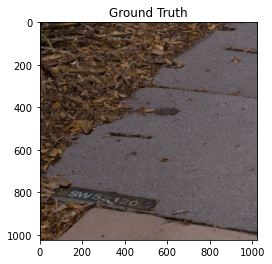

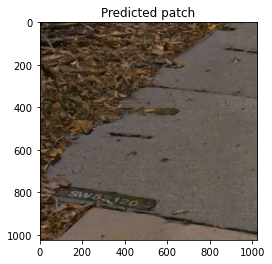

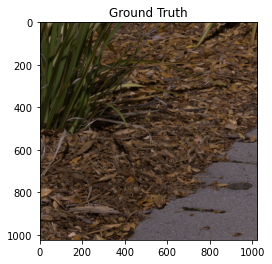

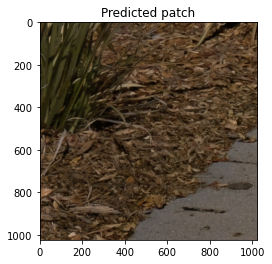

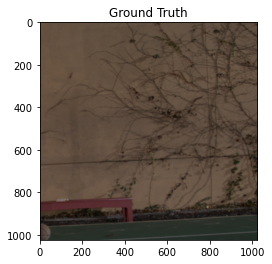

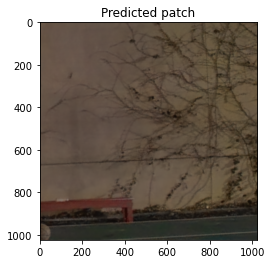

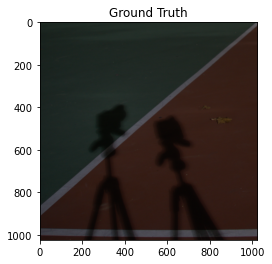

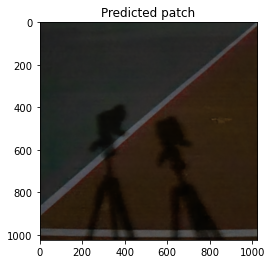

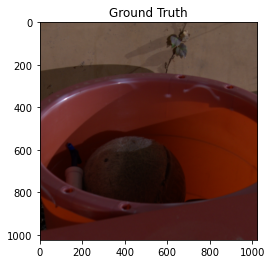

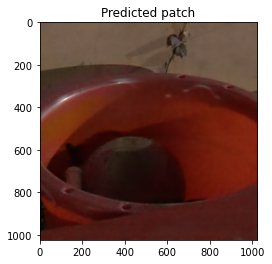

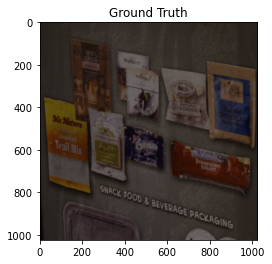

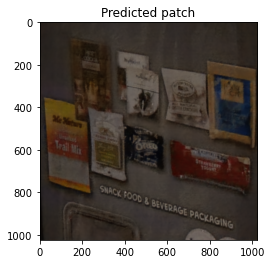

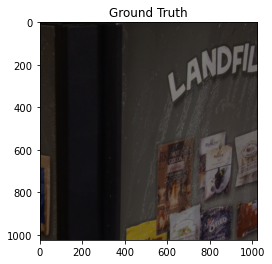

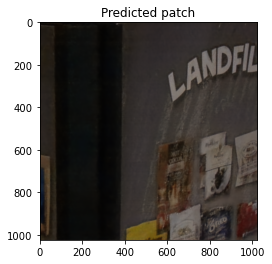

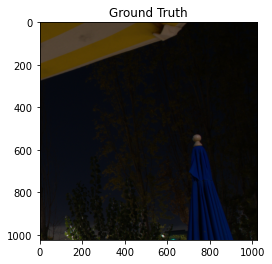

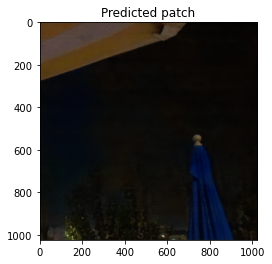

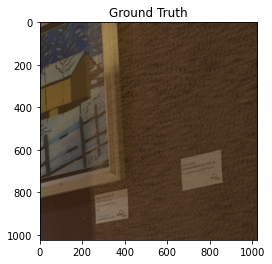

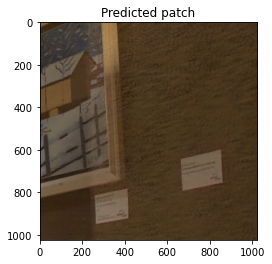

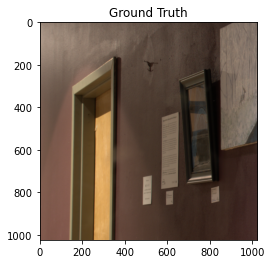

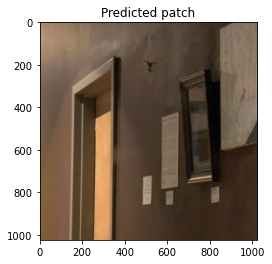

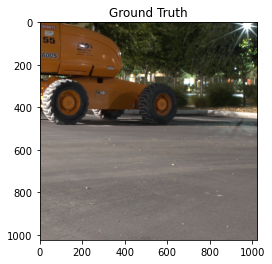

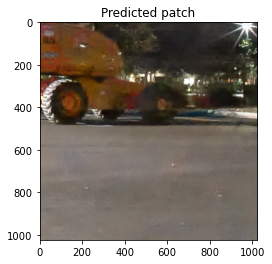

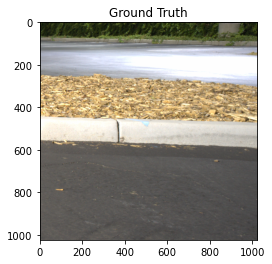

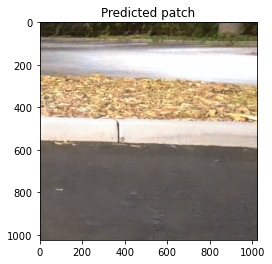

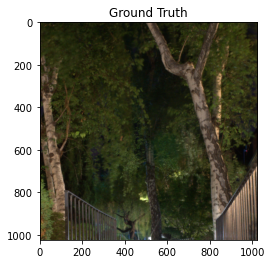

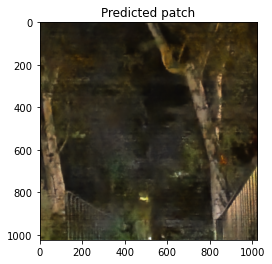

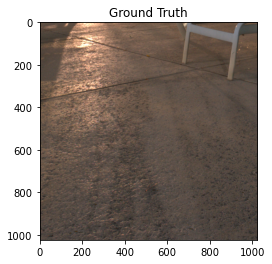

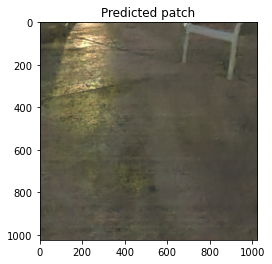

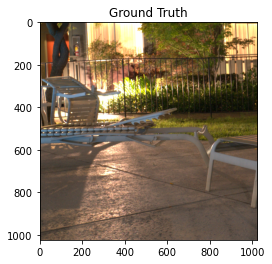

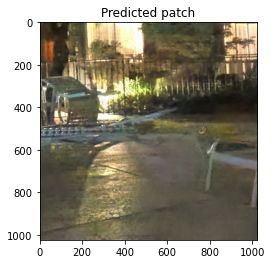

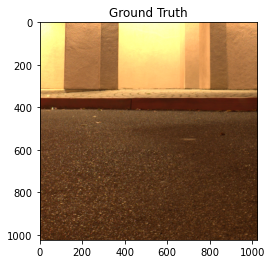

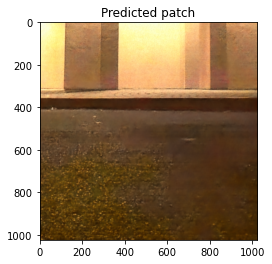

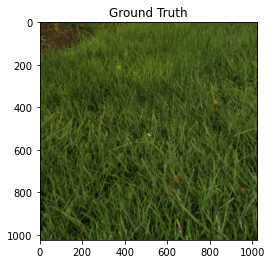

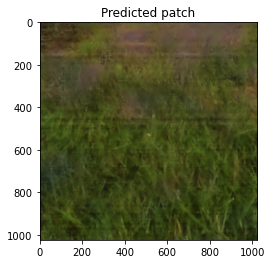

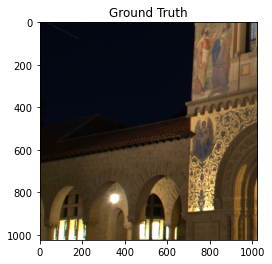

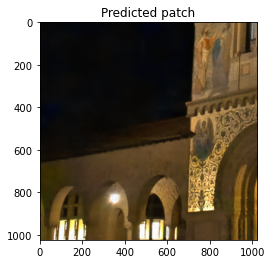

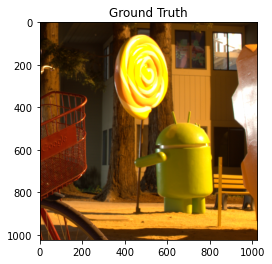

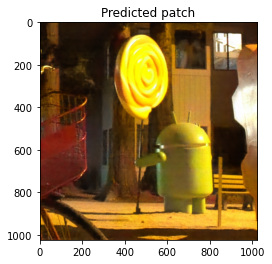

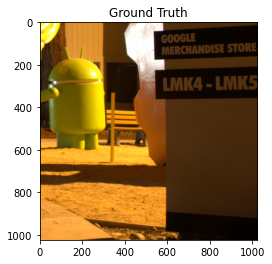

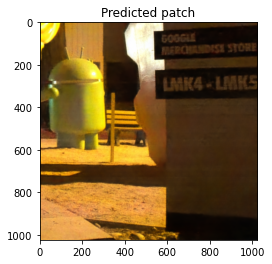

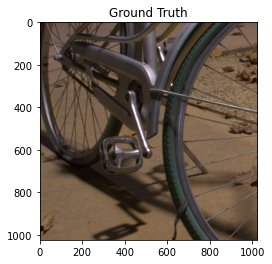

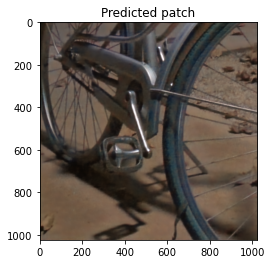

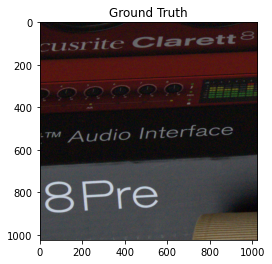

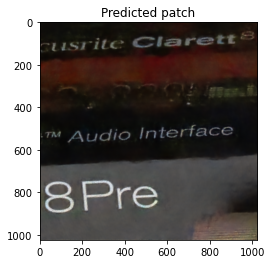

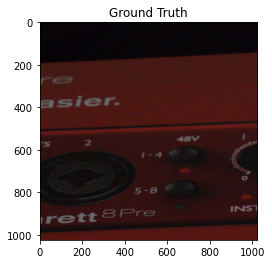

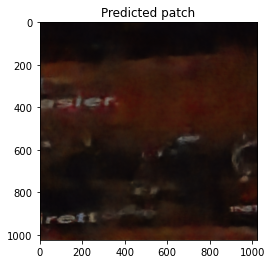

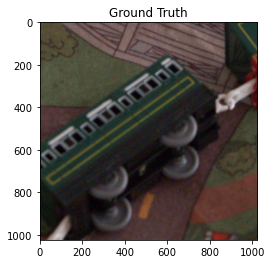

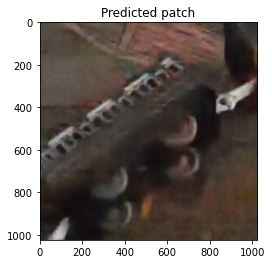

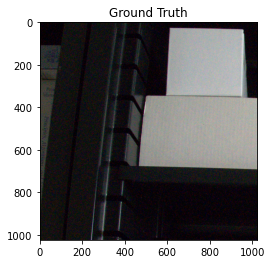

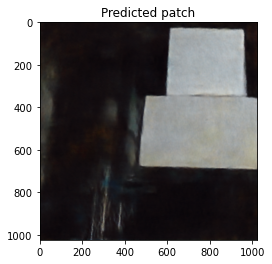

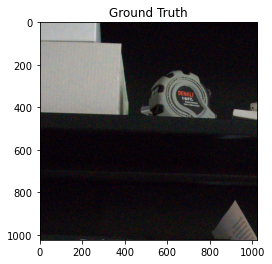

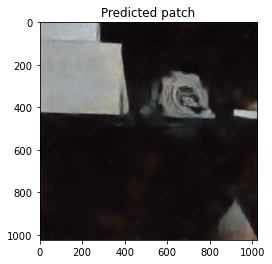

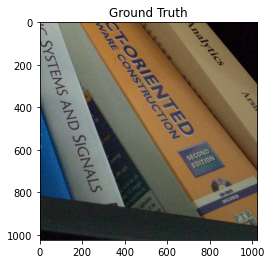

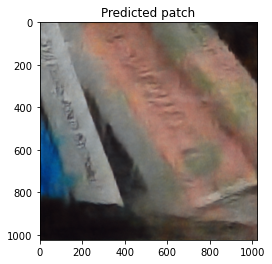

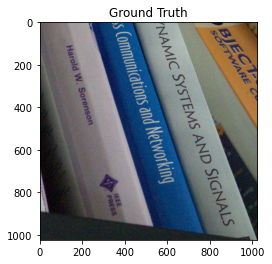

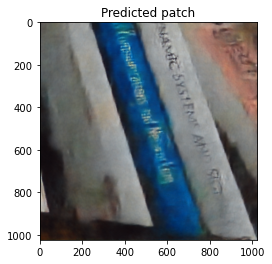

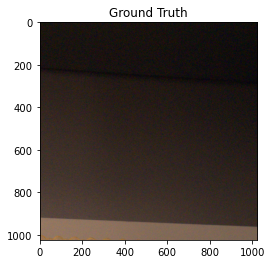

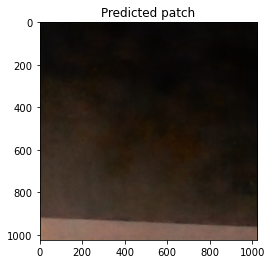

In [14]:
with open('./Dataset/Sony_val_raw_list.pickle','rb') as f:
    val_raw_list = pickle.load(f)
val_raw_list = ['./Dataset/'+path for path in val_raw_list]
with open('./Dataset/Sony_val_gt_list.pickle','rb') as f:
    val_gt_list = pickle.load(f)
val_gt_list = ['./Dataset/'+path for path in val_gt_list]

Val_PSNR = validate(model, val_raw_list, val_gt_list,block_size = 512, batch_size = 8)

In [15]:
print(Val_PSNR)

27.780842


<ipython-input-21-dcfa0b67ce04>:8: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-21-dcfa0b67ce04>:8: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-21-dcfa0b67ce04>:8: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]


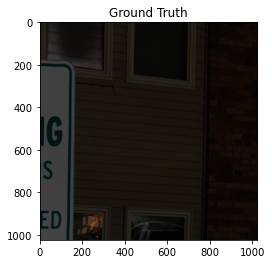

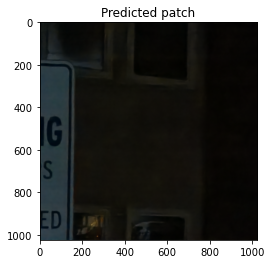

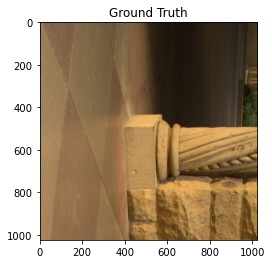

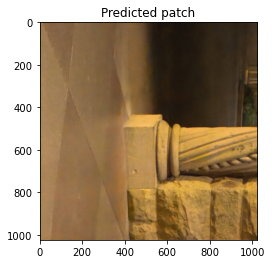

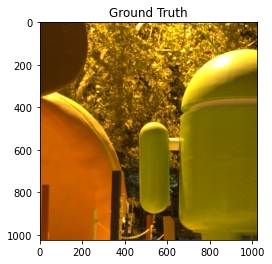

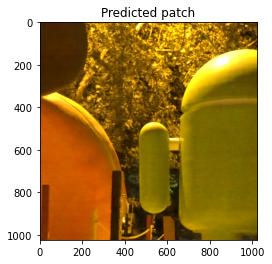

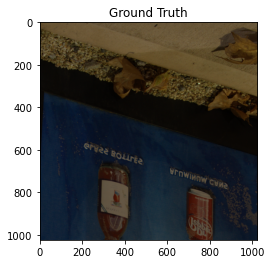

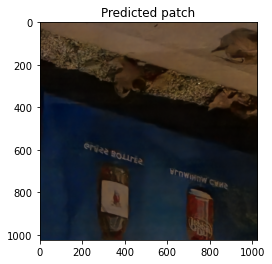

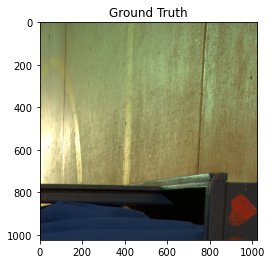

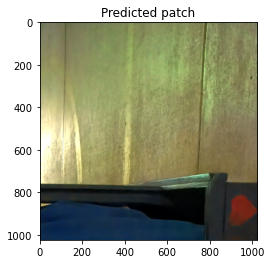

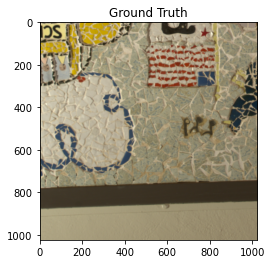

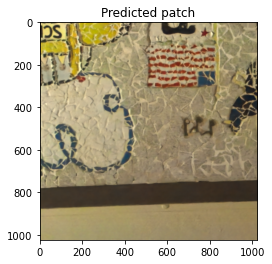

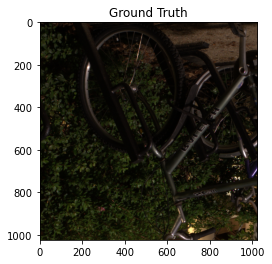

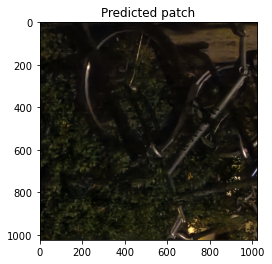

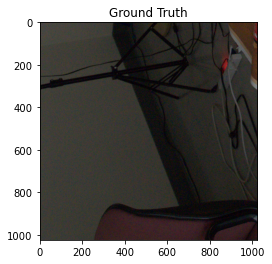

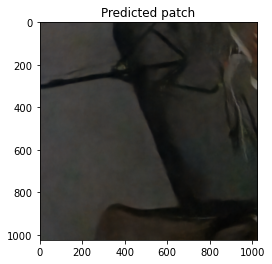

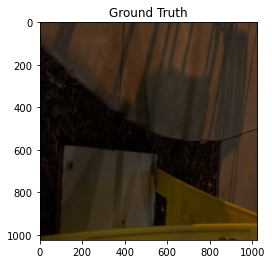

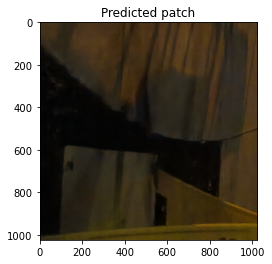

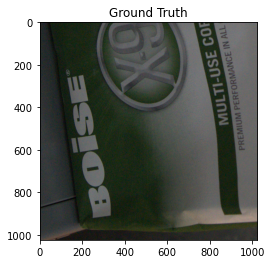

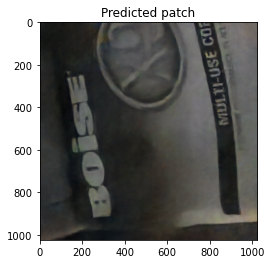

In [21]:
count = 0;
model.eval();
for ind in np.random.permutation(len(train_ids)):
    with torch.no_grad():
        # get the path from image id
        train_id = train_ids[ind]
        in_files = glob.glob(input_dir + '%05d_00*.ARW' % train_id)
        in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        st = time.time()

        if input_images[str(ratio)[0:3]][ind] is None:
            raw = rawpy.imread(in_path)
            input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

        # crop
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))
        #(1, 512, 512, 4)
        #(1, 1024, 1024, 3)
        input_patch = np.transpose(input_patch, (0,3,1,2))
        input_patch = torch.from_numpy(input_patch.copy()).cuda()
        gt_patch = np.transpose(gt_patch, (0,3,1,2))
        gt_patch = torch.from_numpy(gt_patch.copy()).cuda()

        img_pred = model.forward(input_patch)
        count+=1;
        gt_patch = gt_patch[0].cpu()
        img_pred = img_pred[0].cpu()
        gt_patch = np.transpose(gt_patch,(1,2,0))
        img_pred = np.transpose(img_pred,(1,2,0))
        plt.figure()
        plt.imshow(gt_patch)
        plt.title("Ground Truth")
        plt.figure()
        plt.imshow(img_pred)
        plt.title("Predicted patch")
    if count == 10: ## Change this number to change the number of patches shown. 
        break;


In [ ]:
print(gt_patch)
print(img_pred)